# Description
In this notebook we consider the quasi-energies one obtains for the infinite quantum well under a selection of different gauges:
- **Dipole Gauge**:                  $H_d = \frac{\hat{p}^{2}}{2m} + V_{\rm well}(x) - e g \sin(\omega t) \hat{x}$
- **Minimal coupling substitution**: $H_m = \frac{p^{2}}{2m} + V_{\rm well}(x) -e\frac{g}{m\omega}\cos(\omega t)\hat{p} + e^2\frac{g^2}{2m\omega^2}\cos^2(\omega t)$
- **Velocity Gauge**: $H_v = U(t)H_{d}(t)U^\dagger(t) + i\hbar \frac{\partial U(t)}{\partial t}U^\dagger(t)$

Additionally, we also consider the "ground state" quasi energies $\varepsilon_\ell, \varepsilon_v$ obtained from perturbatively accounting from higher energy states (in dipole and minimal coupling substitution hamiltonian respectively) via SWT before truncation. 

In [26]:
from numqt import Mesh, canonic_ops, iw_state, sparse, Hamiltonian
import numpy as np
import matplotlib.pyplot as plt

# ===========================================================
# Parameters and mesh setup
# ===========================================================
a = 1 # bounds of the infinite well
xbounds = (-a, a)
L = np.abs(xbounds[1] - xbounds[0]) # infinite well length
dx = 0.001 # spacial grid finess 
nx = int(np.abs(xbounds[1] - xbounds[0]) / dx) # number of spacial grid points
mesh = Mesh(dims=1, xbounds=xbounds, nx=nx) # mesh over which states will be computed

hbar = 1 # reduced planck constant
m = 1 # particle mass
q = 1 # particle charge

N_states = 30 # number of states to include

# ===========================================================
# Basis & Operators 
# ===========================================================
psi_fn   = lambda n, mesh: iw_state(n, mesh, center= (xbounds[1] + xbounds[0]) / 2 , L=L) # infinite well states
basis    = (psi_fn, N_states) # tuple defining basis 

# Get operators
operators = canonic_ops(mesh, basis=basis, ops_to_compute=["p2","p", "x"], hbar=hbar, threshold=1e-15) # canonical operators that will be used
ops = operators.get_ops() 
px = ops["p"] # momentum
px2 = ops["p2"] # momentum squared
x = ops["x"] # position
x_1n_sqrd = np.array([np.abs(x[0,n])**2 for n in range(1,N_states)]) # |x_1n|^2
identity = sparse.eye(x.shape[0]) # identity operator

H0 = (px2 / (2*m)) # Static Hamiltonian
deltas = np.array([H0[0,0] - H0[n,n] for n in range(1,N_states)]) # E_1 - E_n

# ===========================================================
# Time dependence
# ===========================================================

omega = 10*np.max(np.abs(deltas)) # driving frequency
T = 2 * np.pi / omega # oscillation period
Nt = int(10 * omega) # number of partitions of the computation of U(0, T)

Lw = np.sqrt(hbar / (m * omega)) # charcteristic lenght of drive frequency
L0 = 10*Lw # charcteristic lenght of drive amplitude (i.e. the longer L0, the weaker E0): (hbar**2 / (2 * m * q * E0))**(-1/3)
E0_max = hbar**2 / (2 * m * q * L0**3)
E0_vals = np.linspace(0, E0_max, 100) # driving amplitudes

time_dep_args = {
    "amplitudes": E0_vals,
    "frequencies": omega,
    "periods": T
} # time dependence arguments

# ===========================================================
# Schrieffer-Wolff parameters
# ===========================================================
denom = deltas**2 - (hbar * omega)**2 # E_1 - E_n - (hbar * w)^2

sum_l = np.sum((deltas / denom) * x_1n_sqrd)
sum_v = np.sum((deltas**3 / denom) * x_1n_sqrd)

In [5]:
# ===========================================================
# EXAMPLE 1: Dipole approx
# ===========================================================
print("=== EXAMPLE 1: Dipole approx ===")

# Time-dependent Hamiltonian
def H_dip (E0, w, t): 
    return (- q * E0 * np.cos(w * t) * x)

# Create Hamiltonian with array parameter
H_array_E0 = Hamiltonian(H_time_indep=H0, 
                         H_time_dep=H_dip, 
                         time_dep_args=time_dep_args,  # E0_vals is an array!
                         mesh=mesh,
                         basis=basis,
                         verbose=True)

quasi_energies_dip = H_array_E0.solve_quasi_energies(Nt=Nt)

=== EXAMPLE 1: Dipole approx ===
Starting quasi-energy calculation for 100 parameter set(s)...
Output shape will be: (100, 1, 30)
Parallel computation using all cores.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    1.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  75 out of 100 | elapsed:    1.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  86 out of 100 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


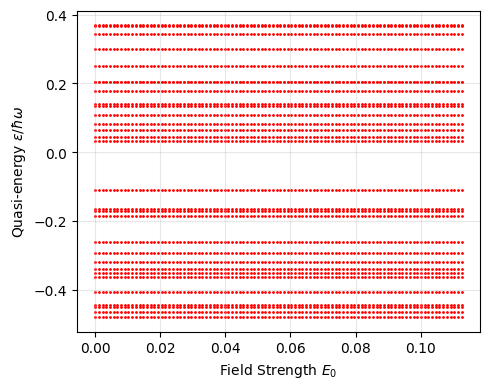

In [17]:
# ===========================================================
# Plotting Dipole
# ===========================================================
fig, ax = plt.subplots(1,1, figsize=(5, 4))

for n in range(N_states):
    ax.scatter(E0_vals, quasi_energies_dip[:, 0, n], c = "r", s=1,  alpha=1)

ax.set_xlabel('Field Strength $E_0$')
ax.set_ylabel('Quasi-energy $\\epsilon / \\hbar\\omega$')
ax.grid(True, alpha=0.3)
#ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()

In [14]:
# ===========================================================
# EXAMPLE 2: Two array parameters (E0_vals and omega_vals)
# ===========================================================
print("\n=== EXAMPLE 2: Arrays of E0 with minimal coupling substituion ===")

def H_mcs(E0, omega, t):
    """Time-dependent Hamiltonian that works with scalar parameters"""
    A_t = E0/omega * np.sin(omega * t)
    return (- q *  A_t * px / m + q**2 * A_t**2 / (2*m) * identity)

# Create Hamiltonian with two array parameters
H_array_mc = Hamiltonian(H_time_indep=H0, 
                         H_time_dep=H_mcs, 
                         time_dep_args=time_dep_args,
                         mesh=mesh,
                         basis=basis,
                         verbose=True)

quasi_energies_mcs = H_array_mc.solve_quasi_energies(Nt=Nt)


=== EXAMPLE 2: Arrays of E0 with minimal coupling substituion ===
Starting quasi-energy calculation for 100 parameter set(s)...
Output shape will be: (100, 1, 30)
Parallel computation using all cores.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    1.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  75 out of 100 | elapsed:    2.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  86 out of 100 | elapsed:    2.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished


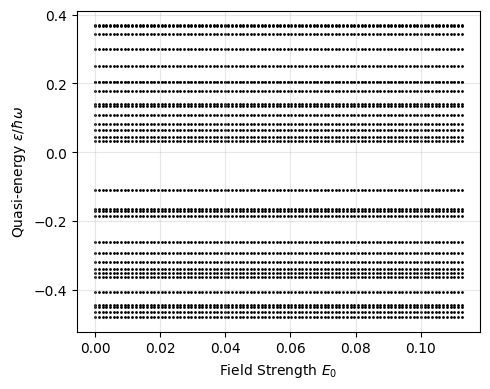

In [16]:
# ===========================================================
# Plotting minimal coupling
# ===========================================================
fig, ax = plt.subplots(1,1, figsize=(5, 4))

for n in range(N_states):
    ax.scatter(E0_vals, quasi_energies_mcs[:, 0, n], c = "k", s=1,  alpha=1)
    
ax.set_xlabel('Field Strength $E_0$')
ax.set_ylabel('Quasi-energy $\\epsilon / \\hbar\\omega$')
ax.grid(True, alpha=0.3)
#ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()

In [18]:
# ===========================================================
# EXAMPLE 3: Velocity Gauge
# ===========================================================
print("\n=== EXAMPLE 3: Results obtained via velocity gauge ===")

def H_vel(E0, omega, t):
    """Time-dependent Hamiltonian that works with scalar parameters"""
    A_t = E0/omega * np.sin(omega * t)
    
    U_vel = sparse.linalg.expm(-1j * q / hbar * A_t * x.tocsc())
    Uc_vel = np.conjugate(U_vel.T)
    return (U_vel @ H0 @ Uc_vel)


H_array_vel = Hamiltonian(H_time_indep= 0*H_vel(1,1,1), 
                             H_time_dep=H_vel, 
                             time_dep_args=time_dep_args,
                             mesh=mesh,
                             basis=basis,
                             verbose=True)

quasi_energies_vel = H_array_vel.solve_quasi_energies(Nt=Nt)


=== EXAMPLE 3: Results obtained via velocity gauge ===
Starting quasi-energy calculation for 100 parameter set(s)...
Output shape will be: (100, 1, 30)
Parallel computation using all cores.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    7.0s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  75 out of 100 | elapsed:    8.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  86 out of 100 | elapsed:    8.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    9.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.8s finished


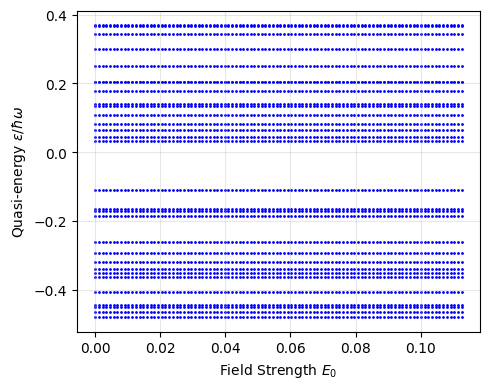

In [20]:
# ===========================================================
# Plotting velocity gauge
# ===========================================================
fig, ax = plt.subplots(1,1, figsize=(5, 4))

for n in range(N_states): 
    ax.scatter(E0_vals, quasi_energies_vel[:,0, n], c = "b", s=1,  alpha=1)

ax.set_xlabel('Field Strength $E_0$')
ax.set_ylabel('Quasi-energy $\\epsilon / \\hbar\\omega$')
ax.grid(True, alpha=0.3)
#ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()

In [23]:
# ===========================================================
# EXAMPLE 4: SWT of Dipole approx
# ===========================================================
print("=== EXAMPLE 4: SW of Dipole approx ===")

# Time-dependent Hamiltonian
def H_sw_dip (E0, w, t): 
    return sparse.csc_array((q**2 * E0**2 * np.sin(w * t)**2 * sum_l) * np.ones((1,1)))

# Create Hamiltonian with array parameter
H_array_E0 = Hamiltonian(H_time_indep=sparse.csc_array(H0[n,n]* np.ones((1,1))), 
                         H_time_dep=H_sw_dip, 
                         time_dep_args=time_dep_args,  # E0_vals is an array!
                         mesh=mesh,
                         basis=basis,
                         verbose=True)

quasi_energies_sw_dip = H_array_E0.solve_quasi_energies(Nt=Nt)

=== EXAMPLE 4: SW of Dipole approx ===
Starting quasi-energy calculation for 100 parameter set(s)...
Output shape will be: (100, 1, 1)
Parallel computation using all cores.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14459991455078125s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  31 out of 100 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  42 out of 100 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of 100 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


In [24]:
# ===========================================================
# EXAMPLE 5: SWT of Minimal coupling approx
# ===========================================================
print("=== EXAMPLE 5: SW of Minimal coupling approx ===")

# Time-dependent Hamiltonian
def H_sw_mcs (E0, w, t): 
    return sparse.csc_array((
        q**2 * E0**2 * np.cos(w * t)**2/(hbar**2 * w**2) * (sum_v + hbar**2 / (2*m)) 
                            ) * np.ones((1,1)))

# Create Hamiltonian with array parameter
H_array_E0 = Hamiltonian(H_time_indep=sparse.csc_array(H0[n,n]* np.ones((1,1))), 
                         H_time_dep=H_sw_mcs, 
                         time_dep_args=time_dep_args,  # E0_vals is an array!
                         mesh=mesh,
                         basis=basis,
                         verbose=True)

quasi_energies_sw_mcs = H_array_E0.solve_quasi_energies(Nt=Nt)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


=== EXAMPLE 5: SW of Minimal coupling approx ===
Starting quasi-energy calculation for 100 parameter set(s)...
Output shape will be: (100, 1, 1)
Parallel computation using all cores.


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1572709083557129s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  31 out of 100 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  42 out of 100 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  86 out of 100 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


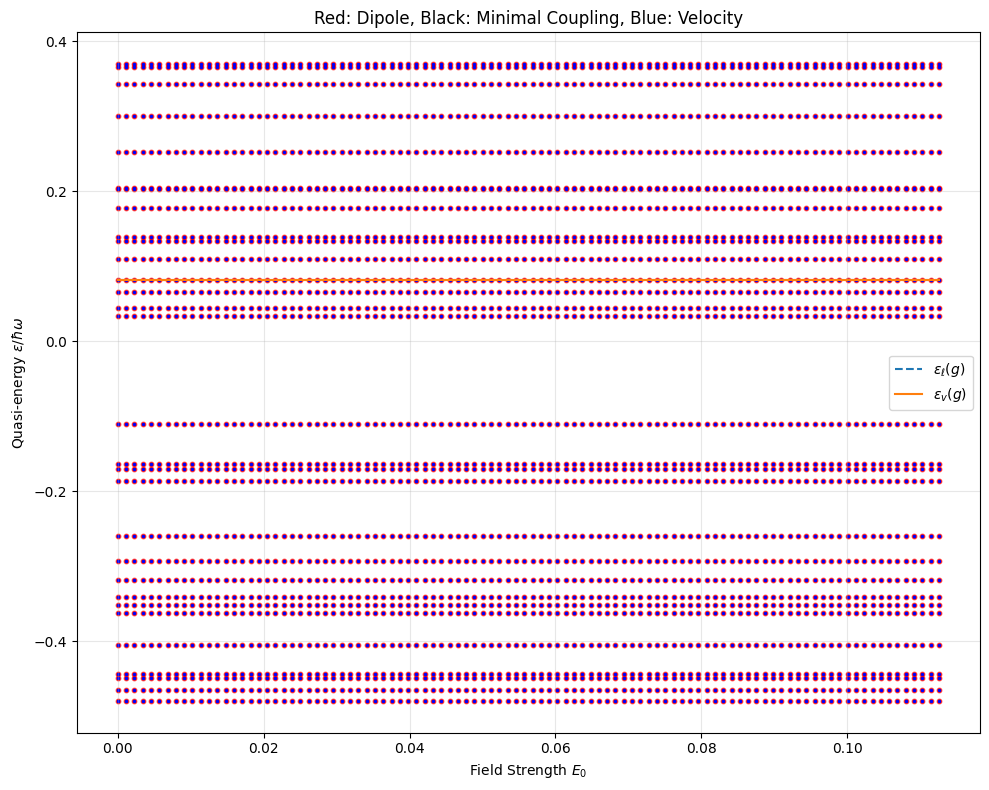

In [27]:
# ===========================================================
# Plotting everything
# ===========================================================

fig, ax = plt.subplots(1,1, figsize=(10, 8))

for n in range(0, N_states): 
    # Dipole quasi energies
    ax.scatter(E0_vals, quasi_energies_dip[:, 0, n], c = "r", s=10,  alpha=0.7, marker="o", zorder=-1) 
    # Minimal coupling quasi energies
    ax.scatter(E0_vals, quasi_energies_mcs[:, 0, n], c = "k", s=1,  alpha=1, zorder=0)
    # Velocity gauge quasi energies
    ax.scatter(E0_vals, quasi_energies_vel[:, 0, n], c = "b", s=2,  alpha=1, zorder=1)

# SW dipole 
ax.plot(E0_vals, quasi_energies_sw_dip[:,0,0], '--', label=r'$\varepsilon_{\ell}(g)$')
ax.plot(E0_vals, quasi_energies_sw_mcs[:,0,0], '-', label=r'$\varepsilon_{v}(g)$')
    

ax.set_xlabel('Field Strength $E_0$')
ax.set_ylabel('Quasi-energy $\\epsilon / \\hbar\\omega$')
ax.set_title('Red: Dipole, Black: Minimal Coupling, Blue: Velocity')
ax.grid(True, alpha=0.3)
#ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
#plt.savefig("dipole_vs_minimal_velocity.pdf", bbox_inches='tight')
plt.legend()
plt.show()